# License Plate Detection by Finding Contours
В этом блокноте мы показываем общую реализацию распознавания номерных знаков с использованием метода контуров.

Контуры являются полезным инструментом для анализа формы, обнаружения и распознавания объектов. Используя обнаружение контуров, мы можем обнаружить границы объектов и, следовательно, легко их локализовать. Важно отметить, что обнаружение контуров может стать самым первым шагом для многих интересных приложений, таких как выделение переднего плана изображения, простая сегментация изображения, обнаружение и распознавание.

[DATASET](https://data.mendeley.com/datasets/nx9xbs4rgx/2)

## Импортируем необходимые библиотеки

In [15]:
!unzip test_dataset.zip

Archive:  test_dataset.zip
   creating: test_dataset/images/
  inflating: test_dataset/images/1.jpg  
  inflating: test_dataset/images/10.jpg  
  inflating: test_dataset/images/100.JPG  
  inflating: test_dataset/images/103.JPG  
  inflating: test_dataset/images/104.JPG  
  inflating: test_dataset/images/105.JPG  
  inflating: test_dataset/images/108.JPG  
  inflating: test_dataset/images/109.JPG  
  inflating: test_dataset/images/11.JPG  
  inflating: test_dataset/images/110.JPG  
  inflating: test_dataset/images/112.JPG  
  inflating: test_dataset/images/113.JPG  
  inflating: test_dataset/images/114.JPG  
  inflating: test_dataset/images/116.JPG  
  inflating: test_dataset/images/117.JPG  
  inflating: test_dataset/images/118.JPG  
  inflating: test_dataset/images/119.JPG  
  inflating: test_dataset/images/12.jpg  
  inflating: test_dataset/images/120.JPG  
  inflating: test_dataset/images/121.JPG  
  inflating: test_dataset/images/122.JPG  
  inflating: test_dataset/images/123.JPG 

In [3]:
!pip install tensorflow

In [16]:
import os
import numpy as np
import pandas as pd
import cv2
import imutils
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
from sklearn.metrics import f1_score

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers

from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

## Загружаем изображения
На этом шаге мы загружаем изображение, содержащее автомобиль с его номерным знаком.

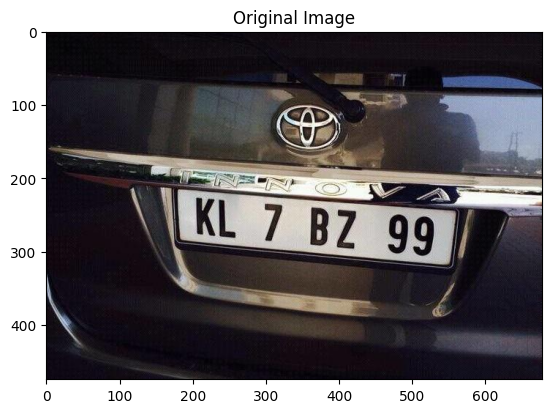

In [21]:
# Read the image file
image = cv2.imread('test_dataset/images/10.jpg')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.show()

## Нахождение контуров
При этом изображение сначала предварительно обрабатывается, а затем отправляется для поиска контуров.
Предварительная обработка изображения содержит следующие этапы:
- **Изменение размера изображения**: Размер каждого изображения увеличивается до ширины 500 пикселей, чтобы облегчить обработку на более поздних этапах.
- **Преобразование в оттенки серого**: Входное изображение в формате RGB. Основная цель этого преобразования - уменьшить количество цветов.
- **Устранение шумов**: Шумы изображения - это искажение изображения, возникающее из-за неисправности камеры или в результате плохой видимости из-за меняющихся погодных условий. Шумы - это также случайное изменение уровней интенсивности пикселей. Шум может быть различных типов, таких как гауссов шум, шум соли и перца. Мы использовали итеративный двусторонний фильтр для удаления шума. Он обеспечивает механизм подавления шума при более эффективном сохранении краев, чем медианный фильтр.
- **Бинаризация**: Бинаризация - это процесс преобразования изображения в изображение со значением только в два пикселя, т.е. содержащее белые и черные пиксели. Выполнение процесса бинаризации перед обнаружением и извлечением номерного знака из изображения облегчит задачу обнаружения номерного знака, поскольку края будут более четкими на двоичном изображении.

После этого изображение готово к обретению контуров.
Первоначально все контуры находятся с помощью методов `cv2.findContours()`. Все контуры площадью менее 30 отбрасываются, а оставшиеся контуры отправляются на дальнейшую обработку. Каждый контур аппроксимируется с образованием многоугольника, и если контур имеет четырехугольную форму (имеет 4 стороны), то предполагается, что это номерной знак, и контуры рисуются с использованием метода `cv2.drawContours()`.

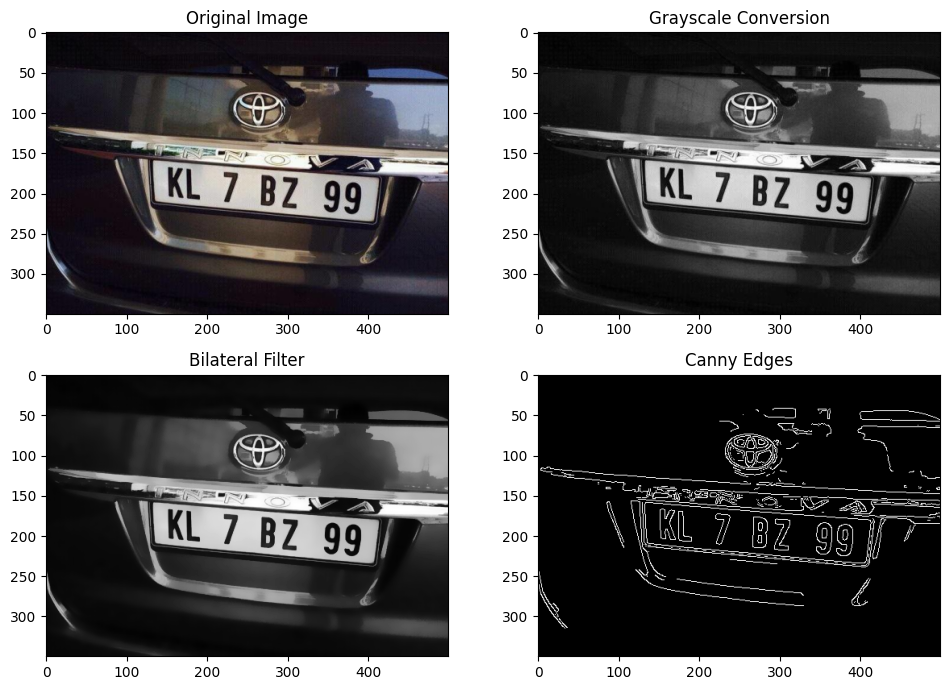

In [22]:
image = imutils.resize(image, width=500)
img=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the original image
fig, ax = plt.subplots(2, 2, figsize=(10,7))
ax[0,0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax[0,0].set_title('Original Image')

# RGB to Gray scale conversion
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ax[0,1].imshow(gray, cmap='gray')
ax[0,1].set_title('Grayscale Conversion')

# Noise removal with iterative bilateral filter(removes noise while preserving edges)
gray = cv2.bilateralFilter(gray, 11, 17, 17)
ax[1,0].imshow(gray, cmap='gray')
ax[1,0].set_title('Bilateral Filter')

# Find Edges of the grayscale image
edged = cv2.Canny(gray, 170, 200)
ax[1,1].imshow(edged, cmap='gray')
ax[1,1].set_title('Canny Edges')

fig.tight_layout()
plt.show()

# Find contours based on Edges
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
cnts=sorted(cnts, key = cv2.contourArea, reverse = True)[:30] #sort contours based on their area keeping minimum required area as '30' (anything smaller than this will not be considered)
NumberPlateCnt = None #we currently have no Number plate contour

# loop over our contours to find the best possible approximate contour of number plate
count = 0
for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:  # Select the contour with 4 corners
            NumberPlateCnt = approx #This is our approx Number Plate Contour
            x,y,w,h = cv2.boundingRect(c)
            ROI = img[y:y+h, x:x+w]
            break

if NumberPlateCnt is not None:
    # Drawing the selected contour on the original image
    cv2.drawContours(image, [NumberPlateCnt], -1, (0,255,0), 3)

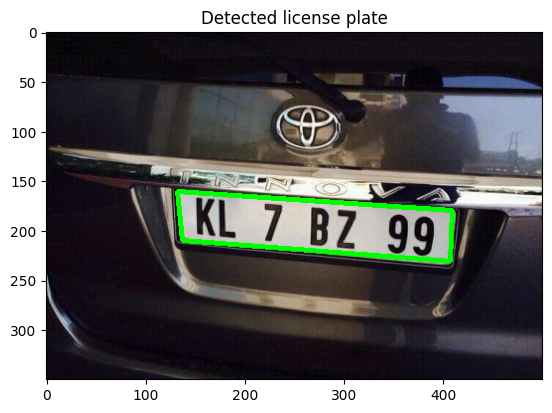

In [23]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Detected license plate")
plt.show()

В зеленой рамке показан обнаруженный номерной знак.

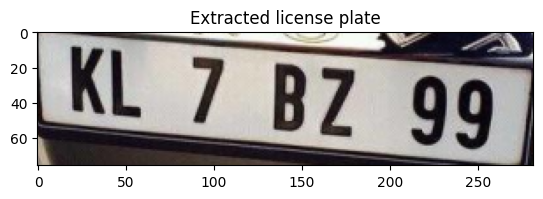

In [24]:
# Find bounding box and extract ROI
plt.imshow(ROI)
plt.title("Extracted license plate")
plt.show()

## Поворот номерного знака (если она наклонена)
Этот шаг полезен, если извлеченный номерной знак наклонен / повернут. На этапе детекции могут возникнуть проблемы, поэтому лучше это исправить.

In [25]:
print(NumberPlateCnt)

[[[132 161]]

 [[137 210]]

 [[407 231]]

 [[409 180]]]


Указанные выше координаты являются координатами обнаруженного номерного знака. Но проблема в том, что мы не знаем, какая координата находится где, потому что контуры могут начинаться откуда угодно и образовывать непрерывный путь.

Идея вращения пластины заключается в том, чтобы найти две нижние координаты. Используя эти две координаты, мы можем легко найти угол поворота. Вскоре это будет проиллюстрировано.

In [26]:
# Distance between (x1, y1) and (x2, y2)
def dist(x1, x2, y1, y2):
    return ((x1-x2)**2+(y1-y2)**2)**0.5

Приведенная выше функция возвращает евклидово расстояние между любыми двумя точками (x1, y1) и (x2, y2).

Как уже обсуждалось, нам нужно найти две нижние координаты:
- Чтобы найти их, мы сначала найдем координату с максимальной y-координатой, и это будет одна из двух крайних нижних координат.
- Теперь другая нижняя координата будет находиться либо слева, либо справа от этой координаты в массиве. Поскольку номерные знаки имеют прямоугольную форму, вторая требуемая координата будет находиться на расстоянии, большем от полученной координаты, чем другая соседняя координата.

In [27]:
idx=0
m=0
# To find the index of coordinate with maximum y-coordinate
for i in range(4):
    if NumberPlateCnt[i][0][1]>m:
        idx=i
        m=NumberPlateCnt[i][0][1]

# Assign index to the previous coordinate
if idx==0:
    pin=3
else:
    pin=idx-1

# Assign index to the next coordinate
if idx==3:
    nin=0
else:
    nin=idx+1

# Find distances between the acquired coordinate and its previous and next coordinate
p=dist(NumberPlateCnt[idx][0][0], NumberPlateCnt[pin][0][0], NumberPlateCnt[idx][0][1], NumberPlateCnt[pin][0][1])
n=dist(NumberPlateCnt[idx][0][0], NumberPlateCnt[nin][0][0], NumberPlateCnt[idx][0][1], NumberPlateCnt[nin][0][1])

# The coordinate that has more distance from the acquired coordinate is the required second bottom-most coordinate
if p>n:
    if NumberPlateCnt[pin][0][0]<NumberPlateCnt[idx][0][0]:
        left=pin
        right=idx
    else:
        left=idx
        right=pin
    d=p
else:
    if NumberPlateCnt[nin][0][0]<NumberPlateCnt[idx][0][0]:
        left=nin
        right=idx
    else:
        left=idx
        right=nin
    d=n
print(left, right)

1 2


Извлеките координаты самых нижних координат таким образом, чтобы `(left_x, left_y)` обозначала нижнюю левую координату, а `(right_x, right_y)` обозначала нижнюю правую координату.

In [28]:
left_x=NumberPlateCnt[left][0][0]
left_y=NumberPlateCnt[left][0][1]
right_x=NumberPlateCnt[right][0][0]
right_y=NumberPlateCnt[right][0][1]
print(left_x, left_y, right_x, right_y)

137 210 407 231


Чтобы повернуть номерной знак, нам нужно найти угол поворота. Это можно выяснить, вычислив sin тэты, используя две координаты. Затем тета может быть извлечена путем нахождения значения, обратного sin. Изображение, наконец, можно повернуть с помощью функции `cv2.getRotationMatrix2D()`.

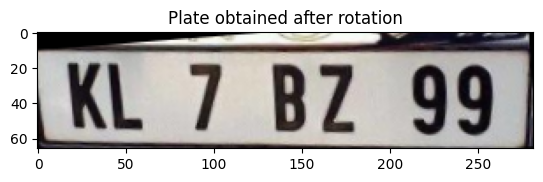

In [29]:
# Finding the angle of rotation by calculating sin of theta
opp=right_y-left_y
hyp=((left_x-right_x)**2+(left_y-right_y)**2)**0.5
sin=opp/hyp
theta=math.asin(sin)*57.2958

# Rotate the image according to the angle of rotation obtained
image_center = tuple(np.array(ROI.shape[1::-1]) / 2)
rot_mat = cv2.getRotationMatrix2D(image_center, theta, 1.0)
result = cv2.warpAffine(ROI, rot_mat, ROI.shape[1::-1], flags=cv2.INTER_LINEAR)

# The image can be cropped after rotation( since rotated image takes much more height)
if opp>0:
    h=result.shape[0]-opp//2
else:
    h=result.shape[0]+opp//2

result=result[0:h, :]
plt.imshow(result)
plt.title("Plate obtained after rotation")
plt.show()

## Сегментация символов
Сегментация символов - это операция, направленная на разложение изображения последовательности символов на подизображения отдельных символов. Это один из процессов принятия решений в системе оптического распознавания символов (OCR).

Этот этап содержит использование двух функций: ``segment_characters()`` и ``find_contours()``.

In [30]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')
            plt.title('Predict Segments')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

В приведенной выше функции мы применим еще некоторую обработку изображений, чтобы извлечь отдельные символы из номерного знака. Необходимые шаги будут заключаться в следующем:
- Поиск всех контуров на входном изображении. Функция cv2.findContours возвращает все контуры, которые она находит на изображении.
- После нахождения всех контуров мы рассматриваем их один за другим и вычисляем размер соответствующего им ограничивающего прямоугольника. Теперь рассмотрим, что ограничивающий прямоугольник - это наименьший из возможных прямоугольников, содержащий контур. Все, что нам нужно сделать, это выполнить некоторую настройку параметров и отфильтровать требуемый прямоугольник, содержащий обязательные символы. Для этого мы выполним некоторое сравнение размеров, приняв только те прямоугольники, которые имеют:
  1. Ширина в диапазоне 0, (длина рисунка)/(количество символов) и,
  2. Длина в диапазоне (ширина рисунка)/2,4*(ширина рисунка)/5. После этого шага мы должны извлечь все символы в виде двоичных изображений.

In [31]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.title('Contour')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

Вышеупомянутая функция принимает изображение в качестве входных данных и выполняет с ним следующую операцию:
- Изменяет его размер таким образом, чтобы все символы казались отчетливыми.
- Преобразуйте цветное изображение в масштабированное изображение серого цвета. Мы делаем это, чтобы подготовить изображение к следующему процессу.
- Теперь функция threshold преобразует изображение в сером масштабе в двоичное изображение, т.е. каждый пиксель теперь будет иметь значение 0 или 1, где 0 соответствует черному, а 1 - белому. Это делается путем применения порогового значения, которое имеет значение от 0 до 255, здесь значение равно 200, что означает, что в изображении в оттенках серого для пикселей, имеющих значение выше 200, в новом двоичном изображении этому пикселю будет присвоено значение 1. И для пикселей, имеющих значение ниже 200, в новом двоичном изображении этому пикселю будет присвоено значение 0.
- Изображение теперь находится в двоичном виде и готово к следующему процессу стирания. Размывание - это простой процесс, используемый для удаления нежелательных пикселей с границы объекта, то есть пикселей, которые должны иметь значение 0, но имеют значение 1.
- Изображение теперь чистое и без граничного шума, теперь мы расширим изображение, чтобы заполнить отсутствующие пиксели, то есть пиксели, которые должны иметь значение 1, но имеют значение 0.
- Теперь следующий шаг - сделать границы изображения белыми. Это делается для удаления любого пикселя вне кадра, если он присутствует.
- Далее мы определяем список измерений, содержащий 4 значения, с которыми мы будем сравнивать размеры символа для фильтрации требуемых символов.
- С помощью вышеуказанных процессов мы сократили наше изображение до обработанного двоичного изображения, и мы готовы передать это изображение для извлечения символов.

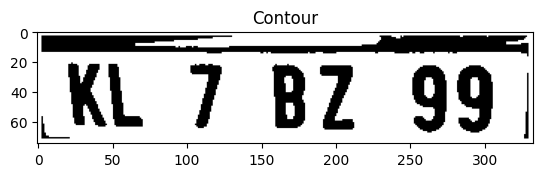

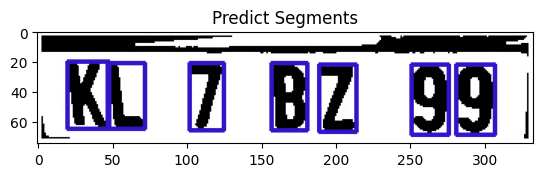

In [32]:
char=segment_characters(result)

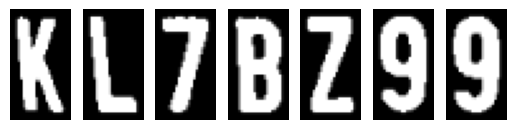

In [33]:
for i in range(len(char)):
    plt.subplot(1, len(char), i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')
plt.show()

## Распознавание символов с помощью CNN
Поскольку все данные почищены и готовы, теперь пришло время создать нейронную сеть, которая будет достаточно интеллектуальной, чтобы распознавать символы после обучения. В этом проекте мы использовали модель CNN для распознавания символов.
- Для обучения модели мы будем использовать класс ImageDataGenerator, доступный в keras, для генерации дополнительных данных с использованием методов увеличения изображения, таких как сдвиг по ширине, сдвиг по высоте.
- Сдвиг по ширине: принимает значение с плавающей точкой, обозначающее, на какую долю изображение будет сдвинуто влево и вправо.
- Сдвиг по высоте: принимает значение с плавающей точкой, обозначающее, на какую долю изображение будет сдвинуто вверх и вниз.

In [34]:
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = 'data'
train_generator = train_datagen.flow_from_directory(
        path+'/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(
        path+'/val',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28 batch_size=1,
        class_mode='sparse')

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


Для модели мы будем использовать 4 сверточных слоя с максимальным объединяющим слоем размером окна = (4,4). Мы также будем использовать 2 плотных слоя, где последние плотные слои будут иметь 36 единиц вывода (26 алфавитов + 10 цифр), а используемая функция активации будет "softmax", потому что это проблема множественной классификации.

Приведенные ниже параметры, используемые в модели, уже были оптимизированы с помощью настройки гиперпараметров.

In [35]:
K.clear_session()
model = Sequential()
model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics='accuracy')

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        23248     
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        131104    
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        131136    
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        65600     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 7, 7, 64)          0         
                                                        

Теперь мы продолжим и протестируем нашу модель. Обратите внимание, что атрибуту ``steps_per_epoch`` присвоено значение ``train_generator.samples // batch_size``, поскольку он обеспечивает использование всех данных поезда за одну эпоху.

In [ ]:
batch_size = 1
result = model.fit(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      epochs = 25, verbose=1, callbacks=None)

Epoch 1/25
864/864 [==============================] - 49s 56ms/step - loss: 3.4449 - accuracy: 0.0789 - val_loss: 1.6070 - val_accuracy: 0.5231
Epoch 2/25
864/864 [==============================] - 48s 55ms/step - loss: 1.3878 - accuracy: 0.6089 - val_loss: 0.5551 - val_accuracy: 0.8426
Epoch 3/25
864/864 [==============================] - 48s 55ms/step - loss: 0.7162 - accuracy: 0.7409 - val_loss: 0.3905 - val_accuracy: 0.8704
Epoch 4/25
864/864 [==============================] - 48s 55ms/step - loss: 0.4096 - accuracy: 0.8562 - val_loss: 0.4356 - val_accuracy: 0.8750
Epoch 5/25
864/864 [==============================] - 48s 55ms/step - loss: 0.3151 - accuracy: 0.8822 - val_loss: 0.4169 - val_accuracy: 0.9167
Epoch 6/25
864/864 [==============================] - 48s 55ms/step - loss: 0.2761 - accuracy: 0.9023 - val_loss: 0.1961 - val_accuracy: 0.9491
Epoch 7/25
864/864 [==============================] - 49s 56ms/step - loss: 0.1855 - accuracy: 0.9491 - val_loss: 0.2616 - val_accuracy:

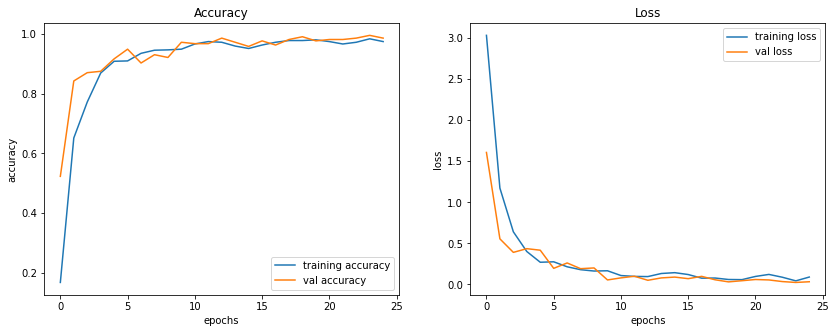

In [ ]:
fig = plt.figure(figsize=(14,5))
grid=gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.plot(result.history['accuracy'], label='training accuracy')
plt.plot(result.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

fig.add_subplot(grid[1])
plt.plot(result.history['loss'], label='training loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

Сохраняем веса модели для использования в будущем.

In [ ]:
# Save the weights
model.save_weights('./checkpoints/my_checkpoint')

Поскольку мы сохранили только веса модели, нам сначала нужно создать экземпляр модели, а затем загрузить сохраненные веса в модель.

In [ ]:
# Create a new model instance
loaded_model = Sequential()
loaded_model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(MaxPooling2D(pool_size=(4, 4)))
loaded_model.add(Dropout(0.4))
loaded_model.add(Flatten())
loaded_model.add(Dense(128, activation='relu'))
loaded_model.add(Dense(36, activation='softmax'))

# Restore the weights
loaded_model.load_weights('checkpoints/my_checkpoint')

## Предсказать номер номерного знака
Теперь у нас готов наш номерной знак и модель CNN! Нам просто нужно предсказать каждого персонажа, используя модель. Для этого мы сначала зафиксируем размер каждого изображения символа, используя функцию ``fix_dimension``, в которой она преобразует изображение в 3-канальное изображение. Затем изображение может быть отправлено в ``model.predict_classes()``, чтобы получить предсказанный символ.

In [ ]:
# Predicting the output
def fix_dimension(img): 
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
        return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        y_ = loaded_model.predict_classes(img)[0] #predicting the class
        character = dic[y_]
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

print(show_results())

G241GH


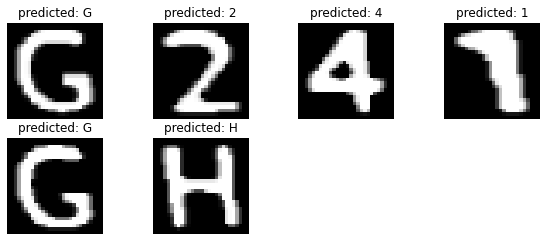

In [ ]:
# Segmented characters and their predicted value.
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()

## Импорт набора данных
Теперь мы импортируем наш набор данных, чтобы рассчитать общую точность этого метода. Набор данных содержит около 200 изображений с labels.xlsx это будет полезно для проверки правильности прогнозируемого результата

In [ ]:
labels=pd.read_excel('test_dataset/labels.xlsx')
labels['ID']=labels['ID'].map(str)
labels

,ID,NUMBER
0,1,KL55R2473
1,2,GJW115A1138
2,3,KL16J3636
3,4,MH20EE7598
4,5,PJJ1L76
...,...,...
181,182,DHF5B15
182,183,DBJ5R59
183,184,LVY8X45
184,185,YYD6B61


## Accuracy


In [ ]:
file_list=os.listdir(r"test_dataset/images")
count=0
for path in file_list:
    no=path[:-4]
    row=labels['NUMBER'].where(labels['ID'] == no).dropna().values[0]
    image = cv2.imread('test_dataset/images/'+path)
    # Resize the image - change width to 500
    image = imutils.resize(image, width=500)
    img=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # RGB to Gray scale conversion
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Noise removal with iterative bilateral filter(removes noise while preserving edges)
    gray = cv2.bilateralFilter(gray, 11, 17, 17)

    # Find Edges of the grayscale image
    edged = cv2.Canny(gray, 170, 200)

    # Find contours based on Edges
    cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
    cnts=sorted(cnts, key = cv2.contourArea, reverse = True)[:30] #sort contours based on their area keeping minimum required area as '30' (anything smaller than this will not be considered)
    NumberPlateCnt = None #we currently have no Number plate contour

    # loop over our contours to find the best possible approximate contour of number plate
    for c in cnts:
            peri = cv2.arcLength(c, True)
            approx = cv2.approxPolyDP(c, 0.02 * peri, True)
            if len(approx) == 4:  # Select the contour with 4 corners
                NumberPlateCnt = approx #This is our approx Number Plate Contour
                x,y,w,h = cv2.boundingRect(c)
                ROI = img[y:y+h, x:x+w]
                break

    idx=0
    m=0
    if NumberPlateCnt is None:
        continue
    for i in range(4):
        if NumberPlateCnt[i][0][1]>m:
            idx=i
            m=NumberPlateCnt[i][0][1]
    if idx==0:
        pin=3
    else:
        pin=idx-1
    if idx==3:
        nin=0
    else:
        nin=idx+1

    p=dist(NumberPlateCnt[idx][0][0], NumberPlateCnt[pin][0][0], NumberPlateCnt[idx][0][1], NumberPlateCnt[pin][0][1])
    n=dist(NumberPlateCnt[idx][0][0], NumberPlateCnt[nin][0][0], NumberPlateCnt[idx][0][1], NumberPlateCnt[nin][0][1])

    if p>n:
        if NumberPlateCnt[pin][0][0]<NumberPlateCnt[idx][0][0]:
            left=pin
            right=idx
        else:
            left=idx
            right=pin
        d=p
    else:
        if NumberPlateCnt[nin][0][0]<NumberPlateCnt[idx][0][0]:
            left=nin
            right=idx
        else:
            left=idx
            right=nin
        d=n
    left_x=NumberPlateCnt[left][0][0]
    left_y=NumberPlateCnt[left][0][1]
    right_x=NumberPlateCnt[right][0][0]
    right_y=NumberPlateCnt[right][0][1]

    opp=right_y-left_y
    hyp=((left_x-right_x)**2+(left_y-right_y)**2)**0.5
    sin=opp/hyp
    theta=math.asin(sin)*57.2958

    image_center = tuple(np.array(ROI.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, theta, 1.0)
    result = cv2.warpAffine(ROI, rot_mat, ROI.shape[1::-1], flags=cv2.INTER_LINEAR)

    if opp>0:
        h=result.shape[0]-opp//2
    else:
        h=result.shape[0]+opp//2

    result=result[0:h, :]
    char=segment_characters(result)
    count=show_results(count)
print("Accuracy: "+str((count/166)*100)+"%")

Accuracy: 60.24096385542169%
